<a href="https://colab.research.google.com/github/giovanna-bardi12/Classificacao-de-pneumonia-em-imagens-de-RAIO-X/blob/main/projetoLigiaPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os


In [ ]:
#Um membro do PS compartilhou esse drive comigo porque tive que refazer o colab uma série de vezes pois perdia a conexão e não conseguia manter os dados, impedindo-me de rodar o notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!ls "/content/drive/MyDrive/cv.dataset/Dados - desafio CV"


test.csv  test_images.zip  train.csv  train.zip


In [14]:
caminho_dataset = "/content/drive/MyDrive/cv.dataset/Dados - desafio CV"
arquivos = os.listdir(caminho_dataset)

print(f"Total de arquivos encontrados: {len(arquivos)}")
print(arquivos)

Total de arquivos encontrados: 4
['train.zip', 'test_images.zip', 'test.csv', 'train.csv']


In [15]:
!cp "/content/drive/MyDrive/cv.dataset/Dados - desafio CV/train.zip" .
!cp "/content/drive/MyDrive/cv.dataset/Dados - desafio CV/test_images.zip" .

#unzip
!unzip -o -q train.zip
!unzip -o -q test_images.zip

print("Arquivos extraídos:")
print(os.listdir("."))

Arquivos extraídos:
['.config', 'dataset', 'test.csv', 'train.csv', 'drive', 'test_images', 'train.zip', 'test_images.zip', 'train', 'sample_data']


In [16]:
import pandas as pd

df_treino = pd.read_csv('train.csv')

print("Colunas do Dataframe:", df_treino.columns.tolist())
print("Primeiras linhas do Dataframe:")
print(df_treino.head())

Colunas do Dataframe: ['id', 'label']
Primeiras linhas do Dataframe:
                         id  label
0  NORMAL-8648239-0004.jpeg      0
1   NORMAL-388586-0003.jpeg      0
2  NORMAL-7824011-0001.jpeg      0
3  NORMAL-8234246-0001.jpeg      0
4  NORMAL-5505017-0001.jpeg      0


# Análise Exploratória de Dados (EDA)

In [22]:
#import das bibliotecas
import random
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import cv2

In [23]:
#pedi a um membro da equipe para criar um drive pois estava tendo muitos problemas com o kaggle então estou reorganizando tudo
!ls train

NORMAL	PNEUMONIA  train


In [19]:
!ls train/train

NORMAL


In [21]:
#Já tinha feito todo o processo então sei qual é o arquivo com o tamanho correto em NORMAL (1349)
print("Quantidade em train/NORMAL:")
!ls train/NORMAL | wc -l
print("\nQuantidade em train/train/PNEUMONIA:")
!ls train/PNEUMONIA | wc -l
print("\nQuantidade em train/train/NORMAL:")
!ls train/train/NORMAL | wc -l

Quantidade em train/NORMAL:
1349

Quantidade em train/train/PNEUMONIA:
3883

Quantidade em train/train/NORMAL:
1297


### Conferir integridade do dataset

In [24]:
pasta_imagens_normal = 'train/NORMAL'
pasta_imagens_pneumonia = 'train/PNEUMONIA'
coluna_imagem = 'id'

#encontrar arquivos da pasta e arquivos listados no csv
arquivos_na_pasta_normal = set(os.listdir(pasta_imagens_normal))
arquivos_na_pasta_pneumonia = set(os.listdir(pasta_imagens_pneumonia))
arquivos_na_pasta = arquivos_na_pasta_normal.union(arquivos_na_pasta_pneumonia)
arquivos_no_csv = set(df_treino[coluna_imagem])

print(f"Total de arquivos na pasta física: {len(arquivos_na_pasta)}")
print(f"Total de registros no CSV: {len(arquivos_no_csv)}")

#verificar presença de nulos
print("Verificando presença de valores nulos:")
print(df_treino.isnull().sum())



Total de arquivos na pasta física: 5232
Total de registros no CSV: 5232
Verificando presença de valores nulos:
id       0
label    0
dtype: int64


### Verificar distribuição das labels

Contagem de cada classe:
label
1    3883
0    1349
Name: count, dtype: int64


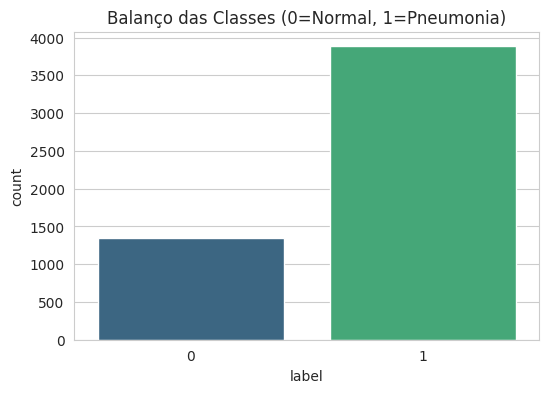

In [25]:
sns.set_style("whitegrid")

#contagem de valores "0" ou "1" na coluna label
contagem = df_treino['label'].value_counts()
print("Contagem de cada classe:")
print(contagem)

#plotar gráfico
plt.figure(figsize=(6, 4))
sns.countplot(x='label', hue='label', data=df_treino, palette='viridis', legend=False)
plt.title('Balanço das Classes (0=Normal, 1=Pneumonia)')
plt.show()

Com esse gráfico podemos perceber que o dataset é desbalanceado. Se não houver pesos o modelo terá a tendência de sempre apresentar o resultado como "pneumonia" e errará mais quando o caso for "normal".

### Inspeção visual das imagens

NORMAL


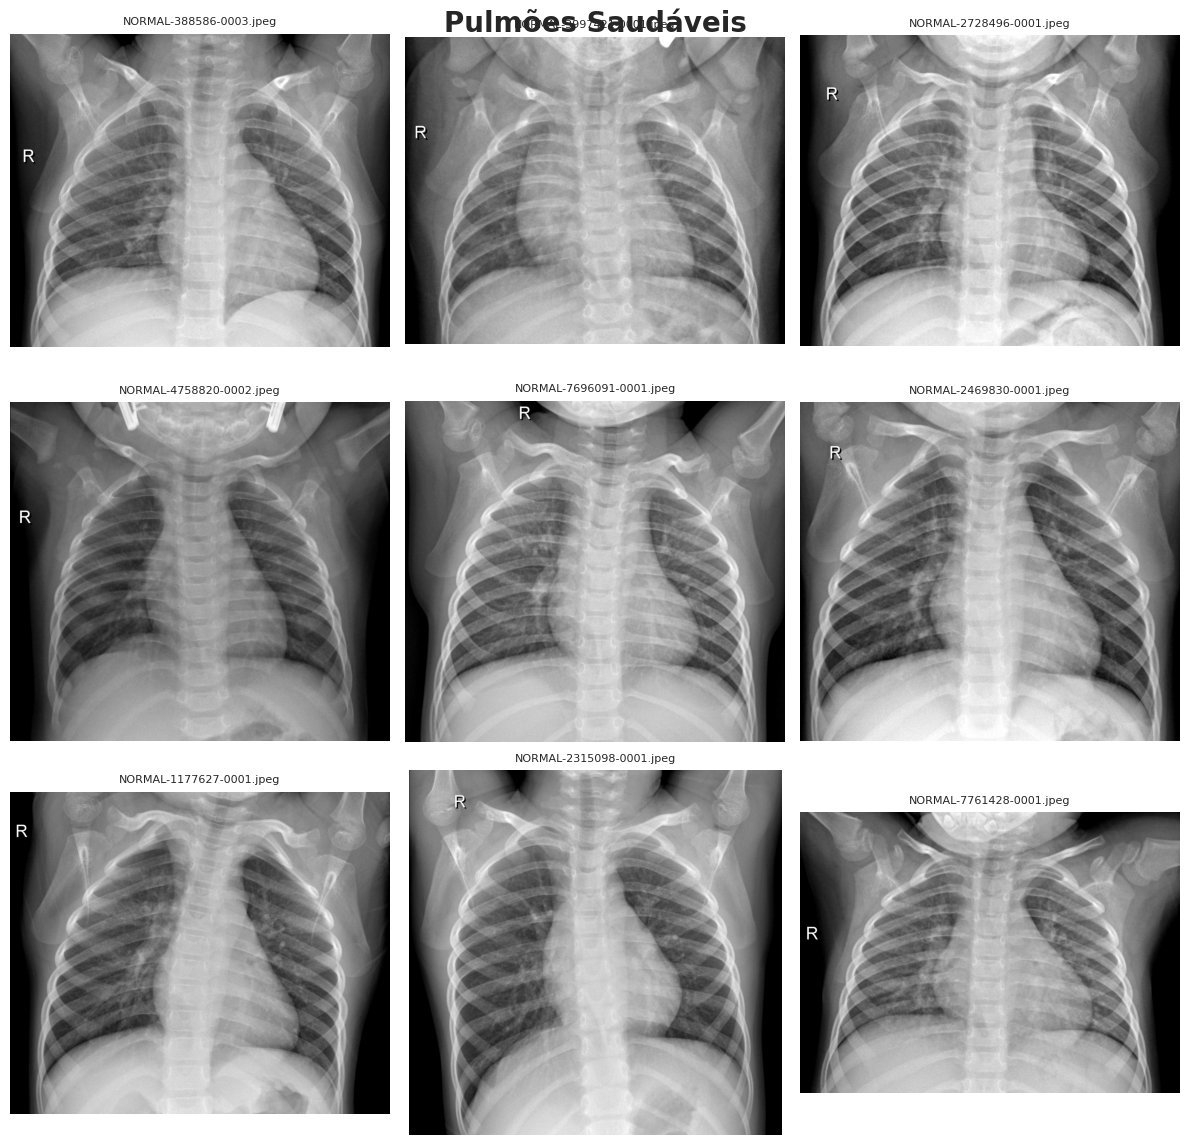


PNEUMONIA


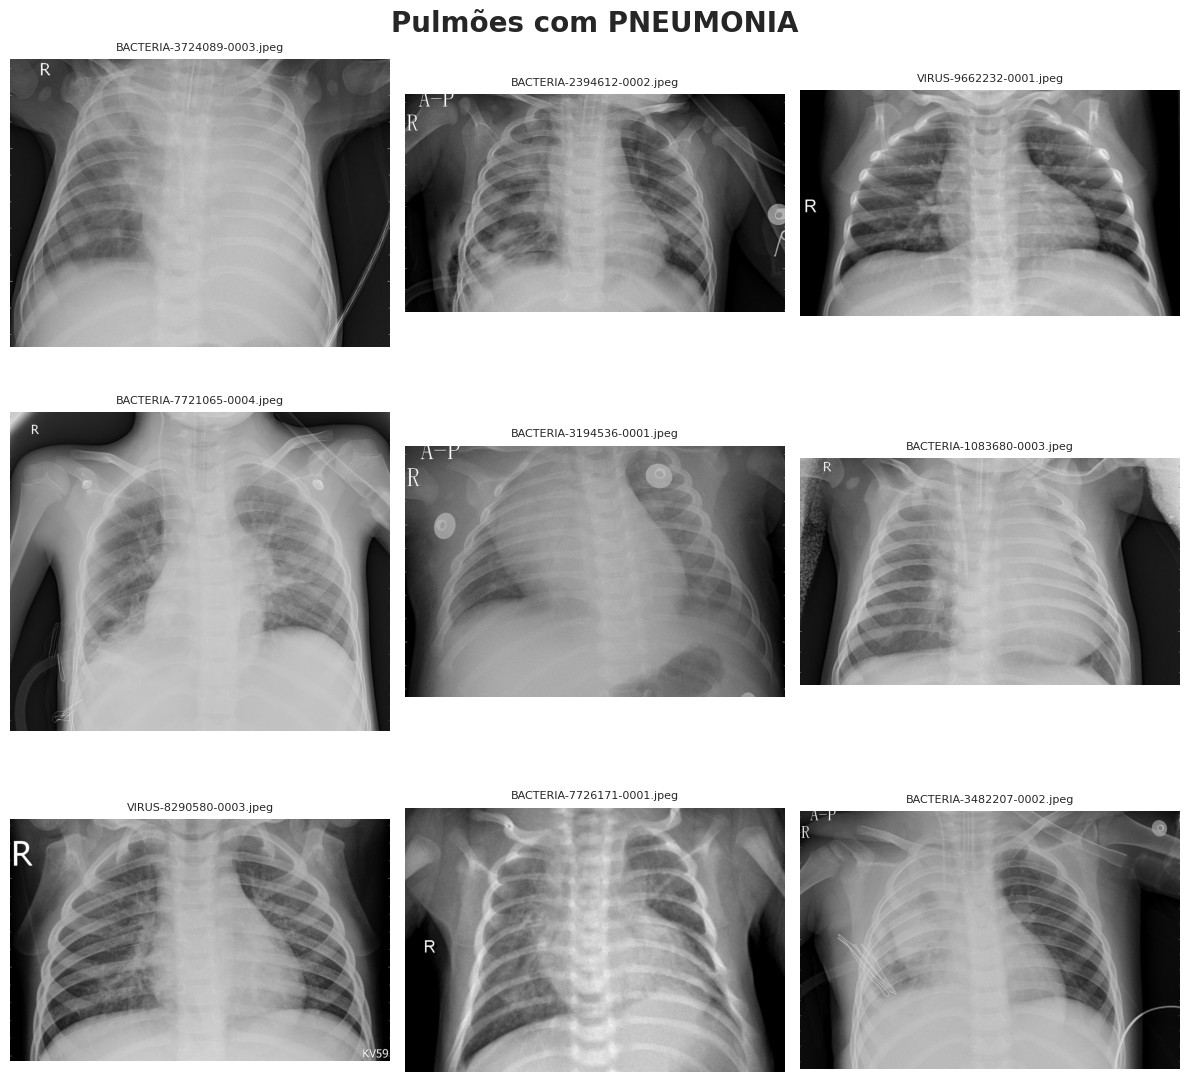

In [27]:
pasta_imagens_normal = 'train/NORMAL'
pasta_imagens_pneumonia = 'train/PNEUMONIA'

def plotar_grid_raiox(diretorio, titulo, linhas=3, colunas=3):
    arquivos = os.listdir(diretorio)
    fig, axes = plt.subplots(linhas, colunas, figsize=(12, 12))
    fig.suptitle(titulo, fontsize=20, weight='bold', y=0.95)
    amostras = random.sample(arquivos, linhas * colunas)

    for i, nome_arquivo in enumerate(amostras):
        img_path = os.path.join(diretorio, nome_arquivo)
        img = mpimg.imread(img_path)

        ax = axes[i // colunas, i % colunas]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(nome_arquivo, fontsize=8)

    plt.tight_layout()
    plt.show()

print("NORMAL")
plotar_grid_raiox(pasta_imagens_normal, "Pulmões Saudáveis")

print("\nPNEUMONIA")
plotar_grid_raiox(pasta_imagens_pneumonia, "Pulmões com PNEUMONIA")

A partir das imagens apresentadas pode-se realizar as seguintes observações:

-As imagens são limpas, com qualidade

-As imagens de pulmões saudáveis tem as costelas nítidas e o fundo, atrás das costelas, é mais escuro

-As imagens de pulmões com pneumonia apresentam uma certa opacidade, o fundo não é tão escuro e existem partes esbranquiçadas

### Análise das imagens

Análise do tamanho das imagens:
Total de tamanhos diferentes encontrados: 4376
5 tamanhos mais comuns:
      Largura  Altura  Qtd
1044     1072     648    7
1085     1080     728    6
1356     1152     664    5
711       992     592    5
794      1008     680    5

Análise de canais de cor:
Total de modos de cor encontrados: 2

Estatísticas do formato de imagem:
count    5232.000000
mean        1.440047
std         0.257115
min         0.835391
25%         1.257206
50%         1.411426
75%         1.583333
max         3.378788
Name: Ratio, dtype: float64


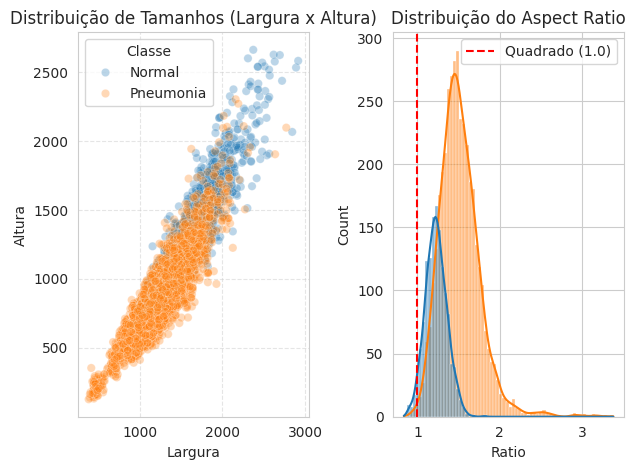

In [28]:
diretorios = {
    'Normal': 'train/NORMAL',
    'Pneumonia': 'train/PNEUMONIA'
}

dados_imagens = []

#essa sequência de loops percorre todas as imagens em ambas as pastas
for classe, diretorio in diretorios.items():
    arquivos = os.listdir(diretorio)
    for arquivo in arquivos:
        caminho = os.path.join(diretorio, arquivo)

        with Image.open(caminho) as img:
                largura, altura = img.size
                modo = img.mode
                razao = largura / altura

                dados_imagens.append({
                    'Classe': classe,
                    'Nome': arquivo,
                    'Largura': largura,
                    'Altura': altura,
                    'Canais': modo,
                    'Ratio': razao
                })

df_imagens = pd.DataFrame(dados_imagens)

print("Análise do tamanho das imagens:")
tamanhos_unicos = df_imagens.groupby(['Largura', 'Altura']).size().reset_index(name='Qtd')
print(f"Total de tamanhos diferentes encontrados: {len(tamanhos_unicos)}")
print("5 tamanhos mais comuns:")
print(tamanhos_unicos.sort_values('Qtd', ascending=False).head())

print("\nAnálise de canais de cor:")
canais_unicos = df_imagens['Canais'].value_counts()
print(f"Total de modos de cor encontrados: {len(canais_unicos)}")

print("\nEstatísticas do formato de imagem:")
print(df_imagens['Ratio'].describe())

#plotar gráficos
#disperção
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_imagens, x='Largura', y='Altura', hue='Classe', alpha=0.3)
plt.title('Distribuição de Tamanhos (Largura x Altura)')
plt.grid(True, linestyle='--', alpha=0.5)

#histograma do ratio
plt.subplot(1, 2, 2)
sns.histplot(data=df_imagens, x='Ratio', hue='Classe', kde=True)
plt.title('Distribuição do Aspect Ratio')
plt.axvline(1.0, color='r', linestyle='--', label='Quadrado (1.0)')
plt.legend()
plt.tight_layout()
plt.show()

A partir dessa análise pode-se perceber algumas coisas:

-Existem 4.376 tamanhos diferentes de imagens. Logo, não há um padrão de tamanho, é preciso na limpeza deixar todos as imagens com o mesmo tamanho

-Mean de 1.44 indica que a maior parte das imagens são retângulares

-Min mostra que existe imagem com altura maior que largura

-Max mostra que exite imagem com largura maior que altura

-Existem dois modos de cor, o ideal será na limpeza converter tudo para RGB

-Os gráficos mostram que as imagens de pulmões saudáveis são mais perto de ser um quadrado, já as imagens de pulmões com pneumonia tem imagens mais retangulares.



### Análise da intesidade dos pixels

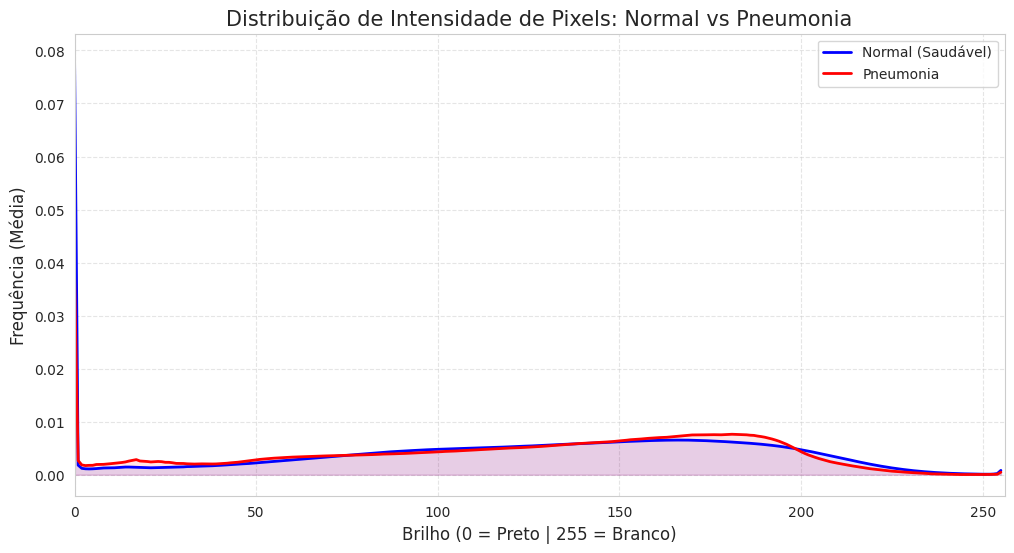

In [29]:
pasta_imagens_normal = 'train/NORMAL'
pasta_imagens_pneumonia = 'train/PNEUMONIA'


def calcular_histograma_medio(diretorio, n_amostras=500):
    arquivos = os.listdir(diretorio)
    amostras = random.sample(arquivos, min(n_amostras, len(arquivos)))
    hists = []

    for nome in amostras:
        img_path = os.path.join(diretorio, nome)
        #ignora rgb, usa escala de cinza
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            hist = cv2.calcHist([img], [0], None, [256], [0, 256])
            hist = hist / hist.sum()
            hists.append(hist)

    return np.mean(hists, axis=0)

hist_normal = calcular_histograma_medio(pasta_imagens_normal)
hist_pneumonia = calcular_histograma_medio(pasta_imagens_pneumonia)

#plotar gráfico
plt.figure(figsize=(12, 6))

plt.plot(hist_normal, color='blue', label='Normal (Saudável)', linewidth=2)
plt.fill_between(range(256), hist_normal.flatten(), color='blue', alpha=0.1)

plt.plot(hist_pneumonia, color='red', label='Pneumonia', linewidth=2)
plt.fill_between(range(256), hist_pneumonia.flatten(), color='red', alpha=0.1)

plt.title('Distribuição de Intensidade de Pixels: Normal vs Pneumonia', fontsize=15)
plt.xlabel('Brilho (0 = Preto | 255 = Branco)', fontsize=12)
plt.ylabel('Frequência (Média)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim([0, 256])
plt.show()


A partir do gráfico percebe-se:

-As imagens de pulmões com pneumonia tem um número maior de pixels mais claros, confirmando a opacidade e partes brancas que foram observadas na análise visual

-Como existe diferença na intensidades de pixels é possível treinar um modelo com maior acurácia

# Pré-processamento e pipeline de dados

In [30]:
import tensorflow as tf

In [31]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 #essa é a CNN selecionada para o treinmento do modelo
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC #parâmetro do processo seletivo disposto nas regras

In [34]:
#configuração
img_size = (224, 224)
batch_size = 32

#redimensionar imagens e criar geradores de dados
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#criar fluxo de treino
train_gen = datagen.flow_from_directory(
    'train/',         #pasta do dataset
    classes=['NORMAL', 'PNEUMONIA'],
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',    #0 ou 1 (conforme label)
    color_mode='rgb',
    subset='training',      #define como conjunto de treino
    shuffle=True,           #evita ordem fixa
    seed=42
)

#criar fluxo de validação
val_gen = datagen.flow_from_directory(
    'train/',
    classes=['NORMAL', 'PNEUMONIA'],
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    subset='validation',   #define como conjunto de prova
    shuffle=False,         #prova não precisa embaralhar
    seed=42
)

print(f"\nMapeamento de Classes: {train_gen.class_indices}")

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.

Mapeamento de Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


Aqui foi feita a padronização das imagens, foi feito a normalização (1/255, logo os valores agora estão entre 0 e 1), dividiu-se o dataset em uma parte para o treino e outra para validação para não acontecer um overfitting (modelo decorar o resultado das imagens)

In [35]:
#com base no EDA
total = 5232
n_normal = 1349
n_pneumonia = 3883

#peso = total de amostras/ numero de classes * amostras da classe
peso_0 = total / (2* n_normal)
peso_1 = total / (2 * n_pneumonia)

pesos = {0: peso_0, 1: peso_1}

print(f"Peso para classe 0: {peso_0:.2f}")
print(f"Peso para classe 1: {peso_1:.2f}")

Peso para classe 0: 1.94
Peso para classe 1: 0.67


### Arquitetura com VGG16

In [36]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False #manter o que o VGG16 já aprendeu

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),             #evita o overfitting
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Treinamento

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Definir Callbacks

In [39]:
#se não melhorar por 5 épocas
early_stop = EarlyStopping(
    monitor = 'val_auc',
    patience = 5,
    mode = 'max', #AUC deve ser maximizado
    restore_best_weights = True,
    verbose = 1
)

#salvar o melhor modelo
checkpoint = ModelCheckpoint(
    'melhor_modelo.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

history = model.fit(
    train_gen,
    epochs=7,
    validation_data=val_gen,
    class_weight=pesos,          #compensa o desbalanceamento
    callbacks=callbacks
)

Epoch 1/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7520 - auc: 0.8029 - loss: 0.5254 
Epoch 1: val_auc improved from -inf to 0.96453, saving model to melhor_modelo.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 2914s 22s/step - accuracy: 0.7525 - auc: 0.8037 - loss: 0.5246 - val_accuracy: 0.9120 - val_auc: 0.9645 - val_loss: 0.2532
Epoch 2/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8943 - auc: 0.9612 - loss: 0.2657 
Epoch 2: val_auc improved from 0.96453 to 0.97457, saving model to melhor_modelo.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 2942s 22s/step - accuracy: 0.8943 - auc: 0.9612 - loss: 0.2657 - val_accuracy: 0.9263 - val_auc: 0.9746 - val_loss: 0.1980
Epoch 3/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9199 - auc: 0.9733 - loss: 0.2118 
Epoch 3: val_auc improved from 0.97457 to 0.98011, saving model to melhor_modelo.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 2920s 22s/step - accuracy: 0.9199 - auc: 0.9732 - loss: 0.2118 - val_accuracy: 0.9368 - val_auc: 0.9801 - val_loss: 0.1740
Epoch 4/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9232 - auc: 0.9789 - loss: 0.1873 
Epoch 4: val_auc improved from 0.98011 to 0.98410, saving model to melhor_modelo.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 2905s 22s/step - accuracy: 0.9232 - auc: 0.9789 - loss: 0.1873 - val_accuracy: 0.9426 - val_auc: 0.9841 - val_loss: 0.1653
Epoch 5/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9323 - auc: 0.9774 - loss: 0.1838 
Epoch 5: val_auc improved from 0.98410 to 0.98589, saving model to melhor_modelo.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 2919s 22s/step - accuracy: 0.9323 - auc: 0.9774 - loss: 0.1837 - val_accuracy: 0.9474 - val_auc: 0.9859 - val_loss: 0.1307
Epoch 6/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9429 - auc: 0.9837 - loss: 0.1611 
Epoch 6: val_auc improved from 0.98589 to 0.98869, saving model to melhor_modelo.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 2841s 22s/step - accuracy: 0.9429 - auc: 0.9837 - loss: 0.1611 - val_accuracy: 0.9493 - val_auc: 0.9887 - val_loss: 0.1345
Epoch 7/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9491 - auc: 0.9875 - loss: 0.1393 
Epoch 7: val_auc improved from 0.98869 to 0.98954, saving model to melhor_modelo.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 2892s 22s/step - accuracy: 0.9490 - auc: 0.9875 - loss: 0.1394 - val_accuracy: 0.9378 - val_auc: 0.9895 - val_loss: 0.1567
Restoring model weights from the end of the best epoch: 7.


In [40]:
!cp melhor_modelo.h5 "/content/drive/MyDrive/cv.dataset/"
print("Backup")

Backup


In [41]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [44]:
modelo = load_model('melhor_modelo.h5')
df_teste = pd.read_csv('test.csv')
previsões = []

#loop percorre imagem por imagem
for imagem in df_teste['id']:
    caminho_imagem = f'test_images/{imagem}'

    #replica o pré-processamento do treino
    img = image.load_img(caminho_imagem, target_size=(224, 224))
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    #probabilidade de ser pneumonia
    probabilidade = modelo.predict(img_array, verbose=0)[0][0]
    classe_prevista = 1 if probabilidade > 0.5 else 0

    previsões.append(classe_prevista)

df_teste['label'] = previsões
df_teste.to_csv('minha_submissao.csv', index=False)

print("Resumo do diagnóstico final:")
print(df_teste['label'].value_counts())

Resumo do diagnóstico final:
label
1    399
0    225
Name: count, dtype: int64


### Plotagem da curva de aprendizagem

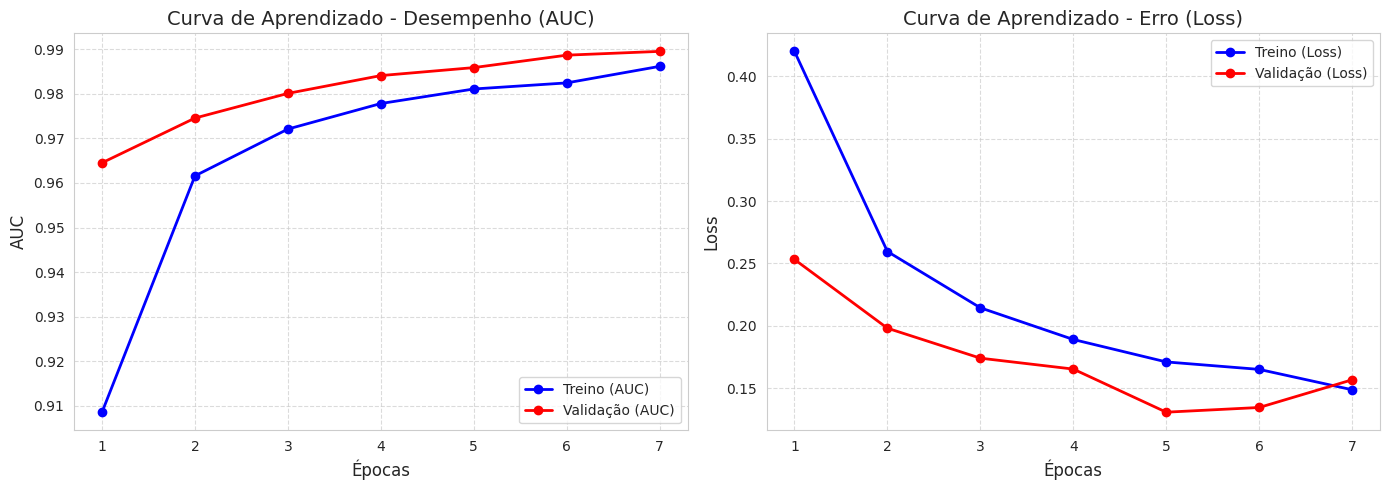

In [45]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epocas = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

#gráfico AUC métrica do acerto
plt.subplot(1, 2, 1)
plt.plot(epocas, acc, 'b-o', label='Treino (AUC)', linewidth=2)
plt.plot(epocas, val_acc, 'r-o', label='Validação (AUC)', linewidth=2)
plt.title('Curva de Aprendizado - Desempenho (AUC)', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

#gráfico função de perda
plt.subplot(1, 2, 2)
plt.plot(epocas, loss, 'b-o', label='Treino (Loss)', linewidth=2)
plt.plot(epocas, val_loss, 'r-o', label='Validação (Loss)', linewidth=2)
plt.title('Curva de Aprendizado - Erro (Loss)', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


A partir dos gráficos pode-se observar:

- O gráfico que dipõe o AUC mede o resultado final da tarefa, é pode-se observar que o desempenho do treino e da validação crescem juntos, indicando uma boa qualidade do modelo.

- Já o segundo gráfico mede se a validação do modelo se aproxima do treino, no quesito da confiança, visto que o modelo não faz uma previsão exata, mas sim um valor entre 0 e 1. Quanto mais a linha do gráfico desce maior a confiança do modelo.